In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simps
from mpl_toolkits.mplot3d import axes3d
# import pymsteams
from time import time, localtime, strftime
from datetime import datetime
import os
# from scipy.interpolate import RegularGridInterpolator as rgi, interp1d
plt.rcParams['figure.figsize'] = [8, 4]
# plt.rcParams.update({'font.size' : 18})

# path = r'C:\Users\fgbse\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'
path = r'C:\Users\Finley Giles-Book\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'

In [167]:
def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape/max(1/((np.pi * (lw)*(1 + ((delta)/(lw))**2))))

def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape

def lorentz_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/(2*np.pi) * (lw + grad*length/2*stark)/((delta + grad*stark*x)**2 + (1/2*(lw + grad*length/2*stark))**2)
    return OD*line_shape/max(1/(2*np.pi) * lw/(delta**2 + (1/2*lw)**2))

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def gauss_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/((lw + grad*length/2*stark)*np.sqrt(2*np.pi)) * np.exp(-1/2 * (delta + grad*stark*x)**2/(lw + grad*length/2*stark)**2)
    return OD*line_shape/max(1/(lw*np.sqrt(2*np.pi)) * np.exp(-1/2 * delta**2/lw**2))

def grad_switch(t,t_switch):
    if t > t_switch:
        return 1
    else:
        return -1
    
def gauss(t,t_peak,amp,sigma):    
    line_shape = amp*np.exp(-(t - t_peak)**2 / (2 * sigma**2))
    return line_shape

def MBE_pol_z0(t, alpha, t0, A, sigma, delta, x, grad, stark, t_switch, g, gamma, w):

    E = gauss(t,t0,A,sigma)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x)*alpha - (1j) * g * w * E

    return dalpha_dt

def interpolate_E_t(E,t_arr,tn):

    interp = np.interp(tn,t_arr,E)
    return interp

def interpolate_E_z(E,x_arr,xn):

    interp = np.interp(xn,x_arr,E)
    return interp

def MBE_pol_z(t, alpha, E, t_arr, delta, x_n, grad, stark, t_switch, g, gamma, w):
    
    Ez = interpolate_E_t(E,t_arr,t)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x_n)*alpha - (1j) * g * w * Ez

    return dalpha_dt

def MBE_field(x, E, delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    E1 = E0*np.exp(-OD*x/L)

    # print(np.shape(E[:,0]))

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK23')
        
    alpha = sol_alpha_z.y.T

    dE_dx = -simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,x=delta,axis=1)

    print(x)

    return dE_dx

In [317]:
def rect_abs_prof_1(x,delta,lw,OD,grad,stark,length):

    line_shape = np.where(abs(delta + grad*stark*x) <= (lw), OD*lw/(lw + grad*length/2*stark), 0)

    return line_shape

def MBE_field(x, E, delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    E1 = E0*np.exp(-OD*x/L)

    # print(np.shape(E[:,0]))

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
        
    alpha = sol_alpha_z.y.T

    # dE_dx = 

    dE_dx = -simps(rect_abs_prof_1(x,delta,lw,OD,grad,stark,L)*alpha,axis=1)

    print(x)

    return dE_dx

In [269]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 1#0.01#0.31                            # Polarization decay rate
g = 50#2000#406                                 # Transition coupling strength
t_input = 5                                 # Gaussian pulse peak time
sigma = 1/np.sqrt(2*np.log(2))        # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 5E5#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.1                                  # Zero field absorption linewidth
t_switch = 15                            # Gradient direction switch time
A = 3.5e-3#3                              # Electric field magnitude
L = 16475/2                               # Optical path length
t_total = 50
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

P = 1j * simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# P = np.rot90(P)

C:\Users\Finley Giles-Book\AppData\Local\Temp\ipykernel_5468\463853473.py:35: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dE_dx = -simps(rect_abs_prof_1(x,delta,lw,OD,grad,stark,L)*alpha,axis=1)


-4118.75
-4118.749499692871
-4118.7399938574135
-4118.734990786121
-4118.709975429656
-4118.705528255173
-4118.6999692870695
-4118.6999692870695
-4118.670083788094
-4118.655141038607
-4118.58042729117
-4118.567144847181
-4118.550541792195
-4118.550541792195
-4118.251686802446
-4118.102259307571
-4117.355121833199
-4117.22229739331
-4117.0562668434495
-4117.0562668434495
-4116.40167741938
-4116.074382707346
-4114.437909147172
-4114.1469805142515
-4113.783319723102
-4113.783319723102
-4111.766946735436
-4110.758760241602
-4105.717827772437
-4104.821662000141
-4103.701454784771
-4103.701454784771
-4099.985473863775
-4098.127483403277
-4088.837531100787
-4087.185984024789
-4085.121550179791
-4085.121550179791
-4081.521599774186
-4079.721624571384
-4070.721748557372
-4069.1217705993254
-4067.121798151767
-4067.121798151767
-4063.2297005692817
-4061.2836517780393
-4051.5534078218266
-4049.823586674055
-4047.661310239341
-4047.661310239341
-4043.8797937097347
-4041.9890354449317
-4032.5352441

C:\Users\Finley Giles-Book\AppData\Local\Temp\ipykernel_5468\3064613186.py:88: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  P = 1j * simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)


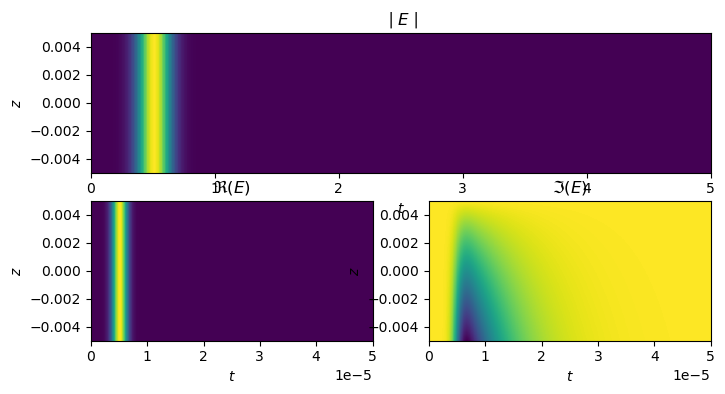

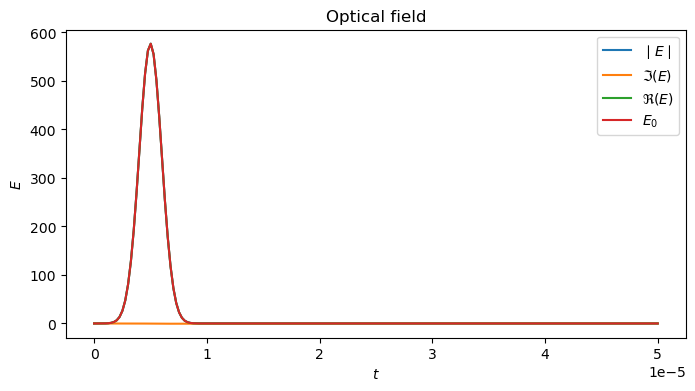

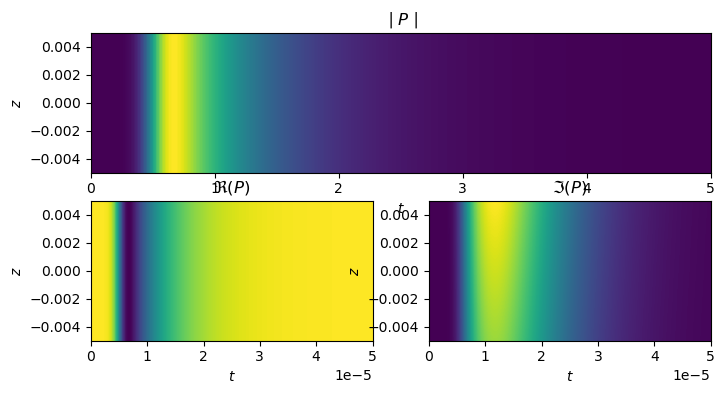

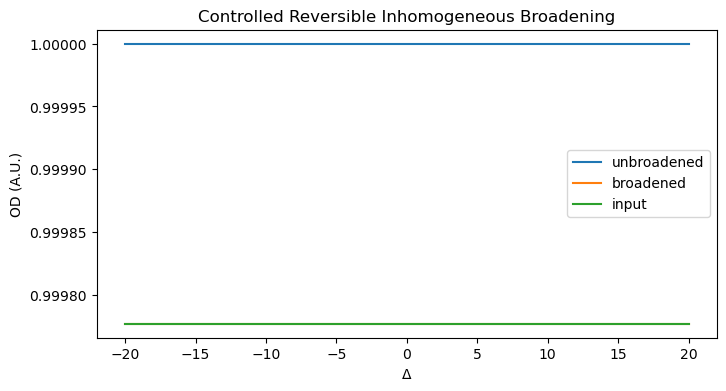

In [288]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
plt.plot(delta,rect_abs_prof_1(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof_1(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()

In [318]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 3.1E5                            # Polarization decay rate
g = 246.45                                 # Transition coupling strength
t_input = 5E-6                                 # Gaussian pulse peak time
sigma = 1E-6                            # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 200000                         # Electric field gradient
stark = 1116                        # Stark coefficient
lw = 0.5E6                                  # Zero field absorption linewidth
t_switch = 15E-6                            # Gradient direction switch time
A = 577                              # Electric field magnitude
L = 1E-2                               # Optical path length
t_total = 50E-6
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20E6  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

# for i in range(Nx):
#     P[:,i] = simps(rect_abs_prof_1(x_arr[i],delta,lw,OD,grad,stark,L)*alpha,axis=2)
# P = np.sum(P,axis=2)
P = 1j * simps(rect_abs_prof_1(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# P = np.rot90(P)

C:\Users\Finley Giles-Book\AppData\Local\Temp\ipykernel_5468\1404893272.py:35: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dE_dx = -simps(rect_abs_prof_1(x,delta,lw,OD,grad,stark,L)*alpha,axis=1)


-0.005
-0.0048410556324310116
-0.003
-0.002
0.003
0.0038888888888888888
0.005
0.005
-0.0034264412539751574
-0.002639661880962736
0.0012942349840993714
0.0019935944267770785
0.002867793730124214
0.002867793730124214
-0.0036975617219306145
-0.003046342582895922
0.00020975311227754145
0.0007886145691972674
0.0015121913903469262
0.0015121913903469262
-0.004033213126021006
-0.003549819689031509
-0.0011328525040840238
-0.000703169448982249
-0.00016606563010502975
-0.00016606563010502975
-0.004279049260319859
-0.003918573890479788
-0.0021161970412794345
-0.0017957744903104832
-0.0013952463015992934
-0.0013952463015992934
-0.004399514952812695
-0.004099272429219042
-0.0025980598112507803
-0.002331177568056423
-0.0019975747640634755
-0.0019975747640634755
-0.0013970897168761706
-0.0010968471932825182
0.0004043654246857443
0.0006712476678801017
0.0010048504718730492
0.0010048504718730492
-0.0014995509349773292
-0.001250539020434256
-5.479447718889814e-06
0.0002158644763193972
0.00049254438136725

C:\Users\Finley Giles-Book\AppData\Local\Temp\ipykernel_5468\693956853.py:91: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  P = 1j * simps(rect_abs_prof_1(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)


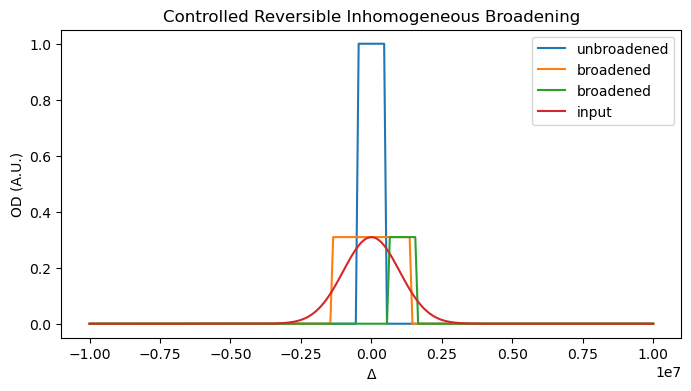

In [325]:
gamma = 3.1E5                            # Polarization decay rate
g = 246.45                                 # Transition coupling strength
t_input = 5E-6                                 # Gaussian pulse peak time
sigma = 1E-6                            # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 200000                         # Electric field gradient
stark = 1116                        # Stark coefficient
lw = 0.5E6                                  # Zero field absorption linewidth
t_switch = 15E-6                            # Gradient direction switch time
A = 577                              # Electric field magnitude
L = 1E-2                               # Optical path length
t_total = 50E-6
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20E6  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

plt.figure()
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,rect_abs_prof_1(x_arr[0],delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()

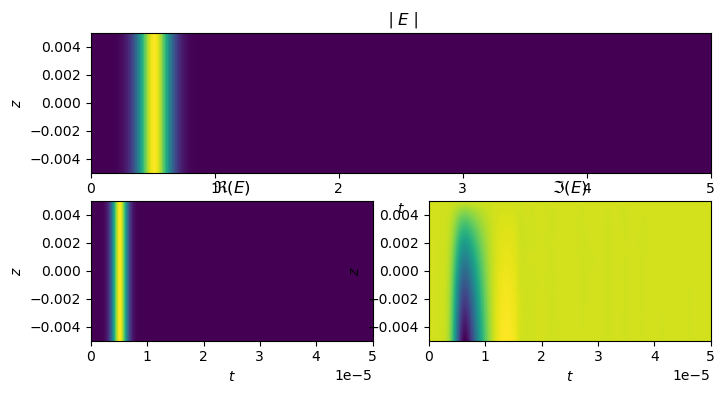

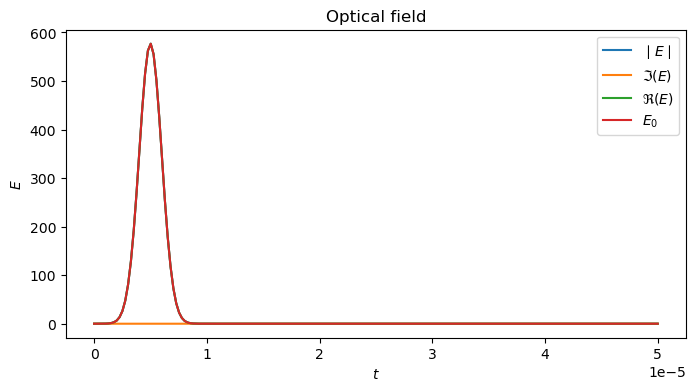

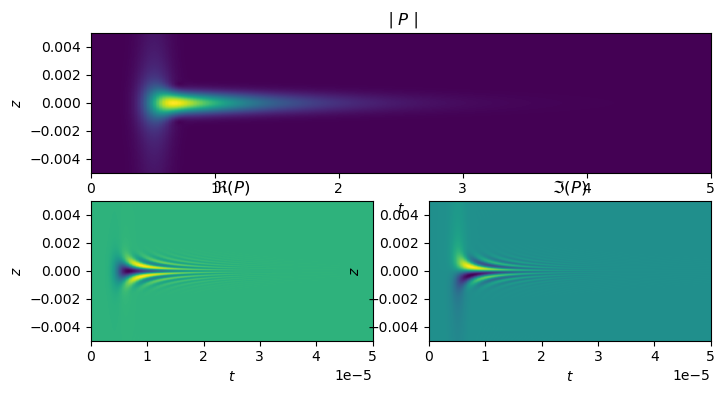

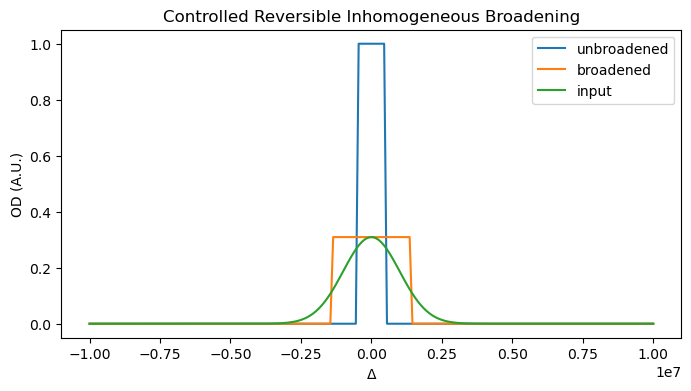

In [319]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss(delta,0,OD*lw/(lw + grad*L/2*stark),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()